In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


%matplotlib inline
from pprint import pprint
import timeit
import re             # regular expression library
from wordcloud import WordCloud
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords

from gensim.corpora.dictionary import Dictionary
from nltk.tokenize import word_tokenize
from collections import Counter
from collections import defaultdict


import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.phrases import Phrases, Phraser
from gensim.models.coherencemodel import CoherenceModel

#from gensim.corpora.dictionary import Dictionary
from gensim.models import TfidfModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import spacy
#nlp = spacy.load('en', disable=['parser', 'ner'])

In [90]:

import matplotlib.colors as mcolors



In [2]:
pwd

'/Users/Robert/DSI/Capstone_3'

In [3]:
# Read datasets/papers.csv into papers
papers = pd.read_csv('nips-papers/papers.csv')


In [4]:
papers.head(3)

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...


In [5]:
papers.tail(3)

,id,year,title,event_type,pdf_name,abstract,paper_text
7238,997,1994,A Real Time Clustering CMOS Neural Engine,NaN,997-a-real-time-clustering-cmos-neural-engine.pdf,Abstract Missing,A Real Time Clustering CMOS\nNeural Engine\nT....
7239,998,1994,Learning direction in global motion: two class...,NaN,998-learning-direction-in-global-motion-two-cl...,Abstract Missing,Learning direction in global motion: two\nclas...
7240,999,1994,Correlation and Interpolation Networks for Rea...,NaN,999-correlation-and-interpolation-networks-for...,Abstract Missing,Correlation and Interpolation Networks for\nRe...


In [6]:
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7241 entries, 0 to 7240
Data columns (total 7 columns):
id            7241 non-null int64
year          7241 non-null int64
title         7241 non-null object
event_type    2422 non-null object
pdf_name      7241 non-null object
abstract      7241 non-null object
paper_text    7241 non-null object
dtypes: int64(2), object(5)
memory usage: 396.1+ KB


In [7]:
drop_cols = ['id', 'event_type', 'pdf_name']
papers.drop(columns=drop_cols, axis=1, inplace=True)

In [10]:
def make_df_LDA_period(low, high):
    '''make a dataframe given upper and lower year bounds'''
 
    df = papers[(papers.year >= low) & (papers.year <= high)]
    df.reset_index(inplace=True)
    print('{0:4d} thru {1:4d} has{2:6d} rows'.format(low, high, len(df)))
          
    return df

In [15]:
papers_1980s = make_df_LDA_period(1987, 1989)

papers_1990s = make_df_LDA_period(1990, 1999)

papers_2000s = make_df_LDA_period(2000, 2009)

papers_2010s = make_df_LDA_period(2010, 2017)


1987 thru 1989 has   285 rows
1990 thru 1999 has  1467 rows
2000 thru 2009 has  2101 rows
2010 thru 2017 has  3388 rows


In [17]:
# Going to go with decade begins in year 1 => papers more evevenly distributed
papers_1980s = make_df_LDA_period(1987, 1990)

papers_1990s = make_df_LDA_period(1991, 2000)

papers_2000s = make_df_LDA_period(2001, 2010)

papers_2010s = make_df_LDA_period(2011, 2017)


1987 thru 1990 has   428 rows
1991 thru 2000 has  1476 rows
2001 thru 2010 has  2241 rows
2011 thru 2017 has  3096 rows


In [18]:
all_df = [papers_1980s, 
papers_1990s, 
papers_2000s,
papers_2010s] 

In [19]:
count = 0
for d in all_df:
    count += len(d)
print(count)
len(all_df)

7241


4

# Preprocess text

In [143]:
# Use stopwords from "nltk.corpus"
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) # sets are efficient
stop_words.update(["this", "that", "thus", "from", "does", "example", "however", "since", "given", 
                    "et", "al", "hence", "therefore", "use", "used", "note", "corresponding", 
                    "setting", "well", "one", "form", "using", "second", "even", "known", "either",
                    "consider", "particular", "general", "represent", "case", "output", "defined",
                    "rather", "though", "although", "set", "problem", "function", "figure", "given",
                    "results", "number", "time", "data", "results", "given", "information", "different",
                    "models", "method", "n", "j", "r", "l", "mj", "a", "cj", "zero", "iv", "is", "elsewhere",
                    "large", "may", "finally", "c", "describing", "l", "cells", "single", "field",
                    "approximation", "activity", "mean", "input", "development", "point", "find", "possible", "follow", 
                    "teacher", "obtain", "term", "obtain", "term", "bind", "show", "high", "compare", "provide",
                    "maintenance", "achievement", "almost", "development"])


In [22]:

# This function removes process the nltk.corpus stopwords. Takes approx 3.25 mins
def rem_stopwords(txt):
    words = txt.split()
    ret_word = words.copy()
    for w in words: 
        if w.lower() in stop_words:
            ret_word.remove(w)
    return (" ".join(ret_word))

for df in all_df:
    df['text_processed'] = df['paper_text'].map(rem_stopwords)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


CPU times: user 3min 14s, sys: 146 ms, total: 3min 14s
Wall time: 3min 14s


In [23]:
%%time
# Tokenize & Remove punctuation. Takes approx 3.75 mins
for df in all_df:
    df['text_processed'] = df['text_processed'].map(lambda text: [w for w in word_tokenize(text.lower()) 
                      if w.isalpha()])
    df['text_string'] = [" ".join(map(str, l)) for l in df['text_processed']]
    # # Print the processed titles of the first rows 
    print(df.head(2))
    print()


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


   index  year                                              title  \
0      0  1987  Self-Organization of Associative Database and ...   
1      1  1987  A Mean Field Theory of Layer IV of Visual Cort...   

           abstract                                         paper_text  \
0  Abstract Missing  767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...   
1  Abstract Missing  683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...   

                                      text_processed  \
0  [associative, database, applications, hisashi,...   
1  [theory, layer, visual, cortex, application, a...   

                                         text_string  
0  associative database applications hisashi suzu...  
1  theory layer visual cortex application artific...  

   index  year                                              title  \
0      3  1994  Bayesian Query Construction for Neural Network...   
1      4  1994  Neural Network Ensembles, Cross Validation, an...   

           abstract       

In [139]:
# # Add more stop words:

STOPWORDS.update(["this", "that", "thus", "from", "does", "example", "however", "since", "given", 
                    "et", "al", "hence", "therefore", "use", "used", "note", "corresponding", 
                    "setting", "well", "one", "form", "using", "second", "even", "known", "either",
                    "consider", "particular", "general", "represent", "case", "output", "defined",
                    "rather", "though", "although", "set", "problem", "function", "figure", "given",
                    "results", "number", "time", "data", "results", "given", "information", "different",
                    "models", "method", "n", "j", "r", "l", "mj", "a", "cj", "zero", "iv", "is", "elsewhere",
                    "large", "may", "finally", "c", "describing", "l", "cells", "single", "field",
                    "approximation", "activity", "mean", "input", "x", "f", "here", "y", "means", "make", "say",
                    "that", "then", "good", "clarify", "b", "t", "layers", "s", "e", "units", "unit", "input", "h", 
                    "z", "p", "xt", "items", "player", "two", "item", "let", "d", "w", "ti", "m", "g", "local",
                    "q", "actions", "users", "system", "regret", "user", "xi", "rule",
                    "eq", "kl", "em", "v", "u", "first", "entries", "optimal", "error", "o", "result",
                    "see", "section", "update", "theorem", "variables", "rl", "st", "size", "based", "fig", "source",
                    "sources", "step", "o", "xi", "vi", "approach", "yt", "c", "new", "unit", "systems", "points", "point",
                    "test", "values", "value", "fi", "examples", "representation", "processing", "shown", "inputs", "initial",
                    "many", "problems", "speaker", "yi", "effect", "gp", "ya", "ylx", "algorithm", "pa", "ga"])
print(len(STOPWORDS))

357


In [25]:
#Further tokenizing 
def tokenize(text):
    return [token for token in text if token not in STOPWORDS]

In [26]:
def token_2(df):
    '''input df, returns tokenized text for that df'''
    paps = df.text_processed
    documents = paps.tolist()
    texts = []
    for doc in documents:
        texts.append(tokenize(doc))
    return(texts)

In [28]:
texts_1980s_0 =  token_2(papers_1980s)
texts_1990s_0 =  token_2(papers_1990s) 
texts_2000s_0 =  token_2(papers_2000s)
texts_2010s_0 =  token_2(papers_2010s)


In [32]:
len(texts_1980s_0[55])

1269

In [33]:
# In case lemmatizing is buggy
def repl_networks(t):
    lis_of_lis = []
    for paper in t:
        words = [word.replace('networks','network') for word in paper]
        words = [word.replace('neurons','neuron') for word in paper]
        lis_of_lis.append(words)
    return (lis_of_lis)

In [34]:
texts_1980s = repl_networks(texts_1980s_0)
texts_1990s = repl_networks(texts_1990s_0) 
texts_2000s = repl_networks(texts_2000s_0)
texts_2010s = repl_networks(texts_2010s_0)


In [35]:
all_texts = [
texts_1980s, 
texts_1990s, 
texts_2000s,
texts_2010s]

len(all_texts)

4

In [36]:
# Make bigrams of certain words
trg_sent = [['machine','learning','neural','network','dummy','neural','networks', "deep", "learning", "dum", "expert", "system", "expert","systems" ], 
            ['neural','networks', 'dummy','neural','network','machine','learning',"deep", "learning", "expert", "system", "expert","systems"]]
phrases = Phrases(trg_sent, min_count=1, threshold=1)
bigram = Phraser(phrases)
test_sent = ['machine','learning','neural','network','neural','networks', "deep", "learning", "expert", "system", "expert", "system"]
print(bigram[test_sent])

['machine_learning', 'neural_network', 'neural_networks', 'deep_learning', 'expert_system', 'expert_system']


In [37]:
# Use spacy to create corpus, takes a few steps
nlp = spacy.load('en', disable=['parser', 'ner'])
def corpus_1(texts):
    corpus = []
    for paper in texts:
        bigram
        corpus.append(bigram[paper])
    return(lemmatization(corpus))

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """see https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [39]:
#This cell takes approx 6 minutes
corpus_1980s  = corpus_1(texts_1980s)
corpus_1990s  = corpus_1(texts_1990s)
corpus_2000s  = corpus_1(texts_2000s)
corpus_2010s  = corpus_1(texts_2010s)


CPU times: user 14min 25s, sys: 8.86 s, total: 14min 34s
Wall time: 6min 10s


In [44]:
corpus_2010s  = corpus_1(texts_2010s)

## Bag of Words and Corpus:


In [45]:
# Build the bag of words
def bow_LDA_topics(corpus):
    frequency = defaultdict(int)
    for text in corpus:
        for token in text:
            frequency[token] += 1
    texts_2 = [[token for token in text if frequency[token] > 10] for text in corpus]
    return(texts_2)
    

In [46]:
texts_2_1980s  = bow_LDA_topics(corpus_1980s)
texts_2_1990s  = bow_LDA_topics(corpus_1990s)
texts_2_2000s  = bow_LDA_topics(corpus_2000s)
texts_2_2010s  = bow_LDA_topics(corpus_2010s)
                           

In [47]:
def build_corpora(texts_2):
    '''returns dictionary and corpus'''
    dictionary = corpora.Dictionary(texts_2)
    corpus_test = []
    for text in texts_2:
        corpus_test.append(dictionary.doc2bow(text))
    return(dictionary, corpus_test)

In [48]:
dict_1980s , corp_1980s  = build_corpora(texts_2_1980s)
dict_1990s , corp_1990s  = build_corpora(texts_2_1990s)
dict_2000s , corp_2000s  = build_corpora(texts_2_2000s)
dict_2010s , corp_2010s  = build_corpora(texts_2_2010s)


In [158]:
pwd

'/Users/Robert/DSI/Capstone_3'

## LDA Model Building:

In [49]:
# Number of topics will be iteratively adjusted per the Coherene score below. 
# The path is where the mallet LDA wrapper is downloaded and unzippeds
n_topics = 20
mallet_path = '/Users/Robert/DSI/Capstone_3/mallet-2.0.8/bin/mallet' # update this path

In [50]:
# Building LDA Mallet Model for 1980s
ldamallet_1980s = gensim.models.wrappers.LdaMallet(mallet_path, 
                                             corpus=corp_1980s, 
                                             num_topics=n_topics, 
                                             id2word=dict_1980s)

In [51]:
# Building LDA Mallet Model for 1990s
ldamallet_1990s = gensim.models.wrappers.LdaMallet(mallet_path, 
                                             corpus=corp_1990s, 
                                             num_topics=n_topics, 
                                             id2word=dict_1990s)

In [52]:
# Building LDA Mallet Model for 2000s
ldamallet_2000s = gensim.models.wrappers.LdaMallet(mallet_path, 
                                             corpus=corp_2000s, 
                                             num_topics=n_topics, 
                                             id2word=dict_2000s)

In [53]:
# Building LDA Mallet Model for 2010s
ldamallet_2010s = gensim.models.wrappers.LdaMallet(mallet_path, 
                                             corpus=corp_2010s, 
                                             num_topics=n_topics, 
                                             id2word=dict_2010s)

In [57]:
# Show Topics
print("****************   Papers 1980s   ***********************************************")
pprint(ldamallet_1980s.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet_1980s = CoherenceModel(model=ldamallet_1980s,
                                                 texts=texts_2_1980s, 
                                                 dictionary=dict_1980s, 
                                                 coherence='c_v')

coherence_ldamallet_1980s = coherence_model_ldamallet_1980s.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet_1980s)

****************   Papers 1980s   ***********************************************
[(9,
  [('function', 0.039473684210526314),
   ('probability', 0.02389544094349586),
   ('distribution', 0.022047174793170216),
   ('threshold', 0.014874141876430207),
   ('space', 0.014654110191867629),
   ('class', 0.013289913747579651),
   ('theory', 0.012937863052279529),
   ('dimension', 0.010517514522091181),
   ('neural_network', 0.010473508185178665),
   ('basis', 0.009417356099278296)]),
 (1,
  [('network', 0.1775615525212343),
   ('feature', 0.038006665949897864),
   ('architecture', 0.026072465326309),
   ('train', 0.02451349317277712),
   ('training', 0.023384582302978175),
   ('task', 0.017417481991183745),
   ('pattern', 0.013439415116654124),
   ('level', 0.012740565530588109),
   ('module', 0.012525534888721643),
   ('expert', 0.012202988925921945)]),
 (18,
  [('net', 0.044099093932790455),
   ('connection', 0.03910998967771533),
   ('parallel', 0.025232251404977635),
   ('processor', 0.01

In [58]:
# Show Topics
print("****************   Papers 1990s   ***********************************************")
pprint(ldamallet_1990s.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet_1990s = CoherenceModel(model=ldamallet_1990s,
                                                 texts=texts_2_1990s, 
                                                 dictionary=dict_1990s, 
                                                 coherence='c_v')

coherence_ldamallet_1990s = coherence_model_ldamallet_1990s.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet_1990s)

****************   Papers 1990s   ***********************************************
[(19,
  [('function', 0.031172289065836075),
   ('bound', 0.021187611464168195),
   ('bind', 0.021124814749692297),
   ('follow', 0.018374318655647936),
   ('class', 0.01367712441285072),
   ('loss', 0.011793222978573761),
   ('complexity', 0.011202933862500314),
   ('assume', 0.010336339202732914),
   ('polynomial', 0.009997236944563061),
   ('theory', 0.009846524829820904)]),
 (7,
  [('word', 0.03275309207512597),
   ('recognition', 0.02913421896472744),
   ('class', 0.02910367995113758),
   ('training', 0.02801954496869751),
   ('classification', 0.023224919835089328),
   ('feature', 0.018796762864559474),
   ('train', 0.018521911742250725),
   ('speech', 0.0159566346007024),
   ('character', 0.01545274087646969),
   ('rate', 0.015345854328905176)]),
 (15,
  [('vector', 0.04093576427024822),
   ('kernel', 0.02639093733329149),
   ('support', 0.019691216619073023),
   ('training', 0.018247717074089183),

In [59]:
# Show Topics
print("****************   Papers 2000s   ***********************************************")
pprint(ldamallet_2000s.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet_2000s = CoherenceModel(model=ldamallet_2000s,
                                                 texts=texts_2_2000s, 
                                                 dictionary=dict_2000s, 
                                                 coherence='c_v')
coherence_ldamallet_2000s = coherence_model_ldamallet_2000s.get_coherence()

print('\nCoherence Score: ', coherence_ldamallet_2000s)

****************   Papers 2000s   ***********************************************
[(17,
  [('kernel', 0.06481934425214403),
   ('space', 0.027988482615560854),
   ('distance', 0.019765317811696957),
   ('dimension', 0.017554723056441377),
   ('vector', 0.01700362240317038),
   ('matrix', 0.014124276293383696),
   ('eigenvalue', 0.011573113718690981),
   ('metric', 0.010359453853060467),
   ('projection', 0.009864082479333725),
   ('embed', 0.009133409703086784)]),
 (13,
  [('label', 0.0527218555247092),
   ('class', 0.035054729339118615),
   ('classification', 0.034324157778046004),
   ('classifier', 0.027958656002439474),
   ('learn', 0.02052588446804861),
   ('instance', 0.018308758600097834),
   ('training', 0.016434683726042017),
   ('rank', 0.013378988761903552),
   ('margin', 0.01306134895274155),
   ('boost', 0.012178310283271182)]),
 (19,
  [('model', 0.08409686572660126),
   ('prior', 0.033714558017631645),
   ('parameter', 0.02940411982584963),
   ('distribution', 0.027389693

In [60]:
# Show Topics
print("****************   Papers 2010s   ***********************************************")
pprint(ldamallet_2010s.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet_2010s = CoherenceModel(model=ldamallet_2010s,
                                                 texts=texts_2_2010s, 
                                                 dictionary=dict_2010s, 
                                                 coherence='c_v')
coherence_ldamallet_2010s = coherence_model_ldamallet_2010s.get_coherence()

print('\nCoherence Score: ', coherence_ldamallet_2010s)

****************   Papers 2010s   ***********************************************
[(6,
  [('matrix', 0.046662356056407416),
   ('vector', 0.014366648192622698),
   ('sparse', 0.013599975367941376),
   ('column', 0.011315351930537594),
   ('noise', 0.00958802881950859),
   ('recovery', 0.008501139232711374),
   ('row', 0.008374899932261839),
   ('recover', 0.008328714822341278),
   ('decomposition', 0.00827637169776464),
   ('sparsity', 0.008208633536547816)]),
 (4,
  [('constraint', 0.03244865703045926),
   ('inference', 0.016304103947388102),
   ('solution', 0.01312804455457886),
   ('factor', 0.011188504360225964),
   ('program', 0.010011816735888473),
   ('variable', 0.009986886913338952),
   ('compute', 0.009752546581373435),
   ('solve', 0.009513220284898012),
   ('message', 0.008800227359981651),
   ('map', 0.008725437892333082)]),
 (12,
  [('policy', 0.050241568776051536),
   ('state', 0.03244600227358848),
   ('learn', 0.025686813186813186),
   ('agent', 0.023176392572944297),


In [72]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):

        model = gensim.models.wrappers.LdaMallet(mallet_path, 
                                                 corpus=corpus, 
                                                 num_topics=num_topics, 
                                                 id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, 
                                        texts=texts, 
                                        dictionary=dictionary, 
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [67]:
#         model = gensim.models.wrappers.LdaMallet(mallet_path, 
#                                                  corpus=corp_1980s, 
#                                                  num_topics=num_topics, 
#                                                  id2word=dict_1980s)
        
#         model_list.append(model)
#         coherencemodel = CoherenceModel(model=model,
#                                         texts=texts_2_1980s, 
#                                         dictionary=dict_1980s, 
#                                         coherence='c_v')
        
#         coherence_values.append(coherencemodel.get_coherence())

0

## Make an LDA Mallet model and calculate coherence scores: graph to choose best number of topics:

In [77]:
# 1980's
# Can take a long time to run 20 - 30 mins
model_list, coherence_values_80s = compute_coherence_values(dictionary=dict_1980s, 
                                                        corpus=corp_1980s, 
                                                        texts=texts_2_1980s, 
                                                        start=2, limit=40, step=6)

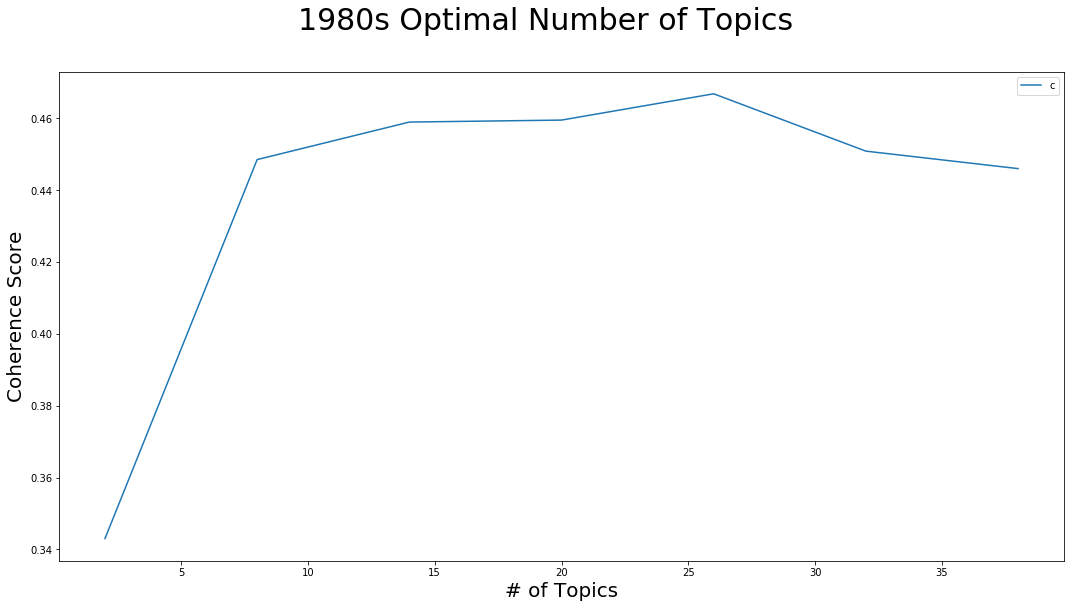

In [94]:
# 1980s
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values_80s)
fig = plt.gcf()
fig.set_size_inches(18, 9)
fig.suptitle('1980s Optimal Number of Topics', fontsize = 30)
plt.xlabel("# of Topics", fontsize = 20)
plt.ylabel("Coherence Score", fontsize = 20)
plt.legend(("coherence_values"), loc='best', fontsize = 10)
plt.savefig('Natural_Language_Processing_NIPS_Papers/images/opt_coh_top_80s.png')
plt.show()


In [79]:
#1990s
# Can take a long time to run  20 - 30 mins
model_list, coherence_values_90s = compute_coherence_values(dictionary=dict_1990s, 
                                                        corpus=corp_1990s, 
                                                        texts=texts_2_1990s, 
                                                        start=2, limit=40, step=6)

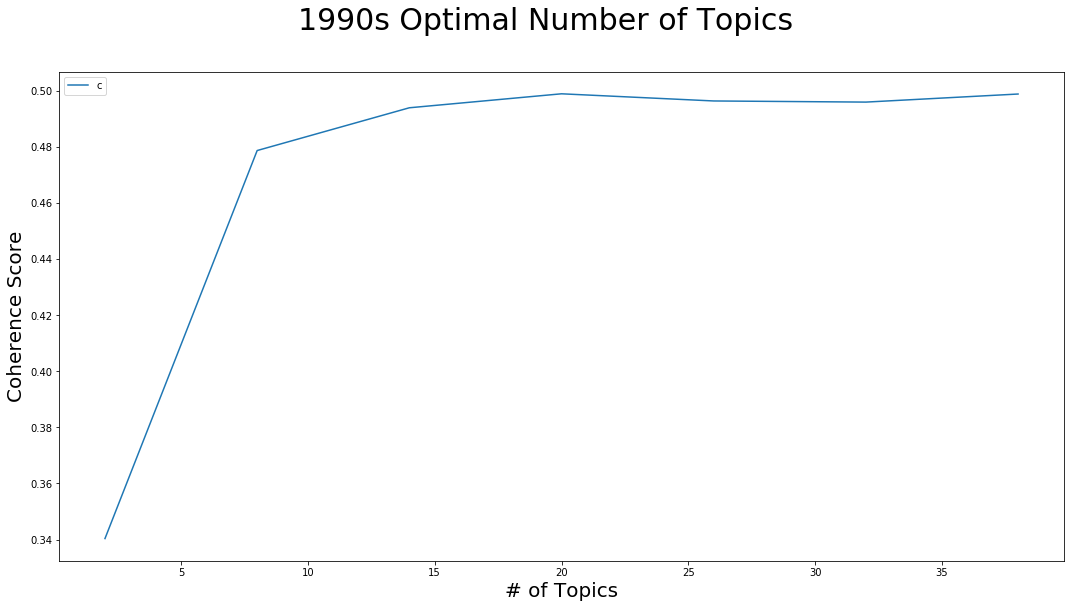

In [95]:
# 1990s
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values_90s)
fig = plt.gcf()
fig.set_size_inches(18, 9)
fig.suptitle('1990s Optimal Number of Topics', fontsize = 30)
plt.xlabel("# of Topics", fontsize = 20)
plt.ylabel("Coherence Score", fontsize = 20)
plt.legend(("coherence_values"), loc='best', fontsize = 10)
plt.savefig('Natural_Language_Processing_NIPS_Papers/images/opt_coh_top_90s.png')
plt.show()


In [84]:
# 2000s
# Can take a long time to run  20 - 30 mins
model_list, coherence_values_00s = compute_coherence_values(dictionary=dict_2000s, 
                                                        corpus=corp_2000s, 
                                                        texts=texts_2_2000s, 
                                                        start=2, limit=40, step=6)

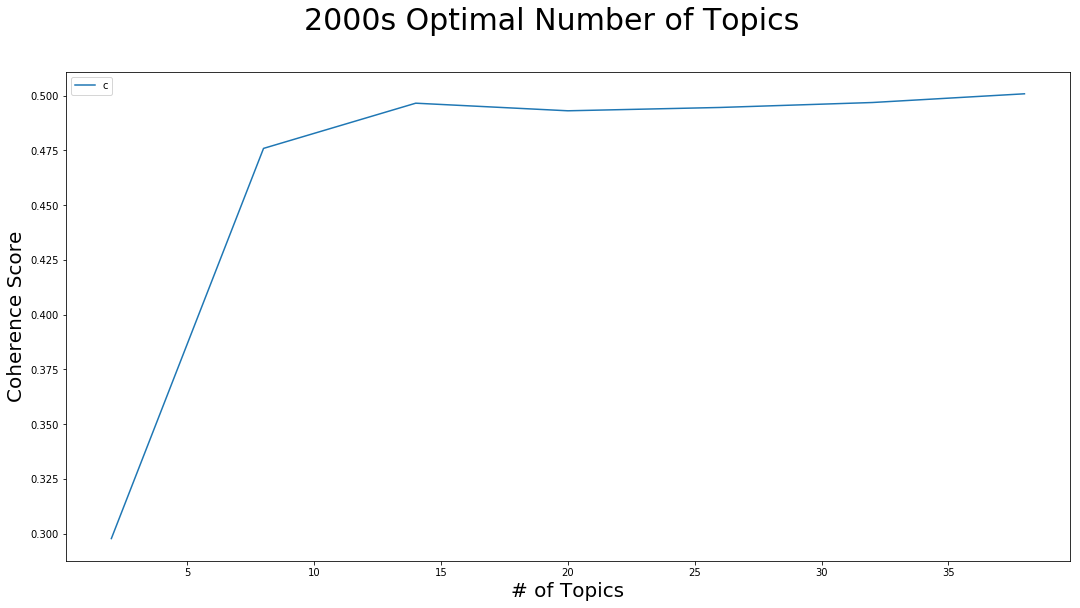

In [96]:
# 2000s
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values_00s)
fig = plt.gcf()
fig.set_size_inches(18, 9)
fig.suptitle('2000s Optimal Number of Topics', fontsize = 30)
plt.xlabel("# of Topics", fontsize = 20)
plt.ylabel("Coherence Score", fontsize = 20)
plt.legend(("coherence_values"), loc='best', fontsize = 10)
plt.savefig('Natural_Language_Processing_NIPS_Papers/images/opt_coh_top_00s.png')
plt.show()


In [89]:
# 2010s
# Can take a long time to run 30 mins
model_list, coherence_values_10s = compute_coherence_values(dictionary=dict_2010s, 
                                                        corpus=corp_2010s, 
                                                        texts=texts_2_2010s, 
                                                        start=2, limit=40, step=6)

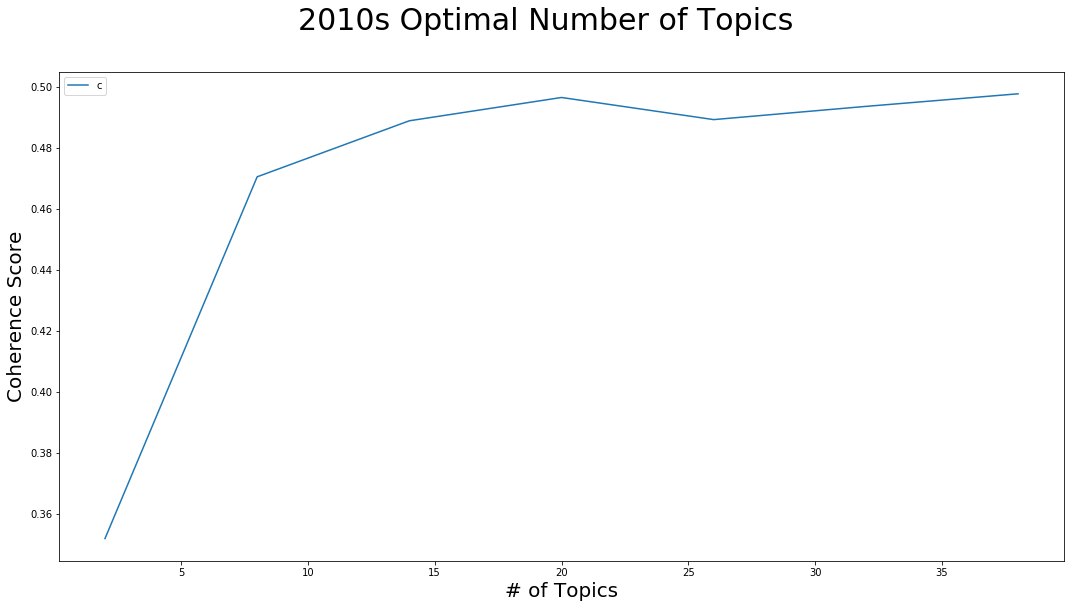

In [97]:
# 2010s
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values_10s)
fig = plt.gcf()
fig.set_size_inches(18, 9)
fig.suptitle('2010s Optimal Number of Topics', fontsize = 30)
plt.xlabel("# of Topics", fontsize = 20)
plt.ylabel("Coherence Score", fontsize = 20)
plt.legend(("coherence_values"), loc='best', fontsize = 10)
plt.savefig('Natural_Language_Processing_NIPS_Papers/images/opt_coh_top_10s.png')
plt.show()


## Now use coherence analysis to show results in Wordclouds for each decade

In [141]:
# Build 1980s LDA model
lda_model_80s = gensim.models.ldamodel.LdaModel(corpus=corp_1980s,
                                           id2word=dict_1980s,
                                           num_topics=14,         #this can be changed, 1980s per graph: either 8 or 14 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model_80s.print_topics())

[(0,
  '0.054*"circuit" + 0.040*"interconnect" + 0.039*"current" + '
  '0.032*"implementation" + 0.032*"intensity" + 0.028*"design" + 0.024*"chip" '
  '+ 0.022*"gate" + 0.019*"store" + 0.019*"implement"'),
 (1,
  '0.025*"structure" + 0.022*"pattern" + 0.020*"role" + 0.019*"map" + '
  '0.018*"represent" + 0.016*"distribute" + 0.014*"path" + 0.014*"connection" '
  '+ 0.013*"simulation" + 0.012*"strength"'),
 (2,
  '0.011*"probability" + 0.009*"function" + 0.009*"vector" + 0.008*"parameter" '
  '+ 0.008*"model" + 0.008*"find" + 0.008*"follow" + 0.008*"possible" + '
  '0.007*"space" + 0.007*"order"'),
 (3,
  '0.131*"retinal" + 0.127*"almost" + 0.125*"eye" + 0.062*"dominance" + '
  '0.049*"monkey" + 0.047*"stripe" + 0.042*"ocular" + 0.035*"cortical" + '
  '0.032*"growth" + 0.029*"development"'),
 (4,
  '0.055*"state" + 0.043*"model" + 0.039*"learn" + 0.036*"control" + '
  '0.032*"sequence" + 0.028*"symbol" + 0.021*"environment" + 0.020*"cycle" + '
  '0.019*"arm" + 0.017*"memory"'),
 (5,
  '

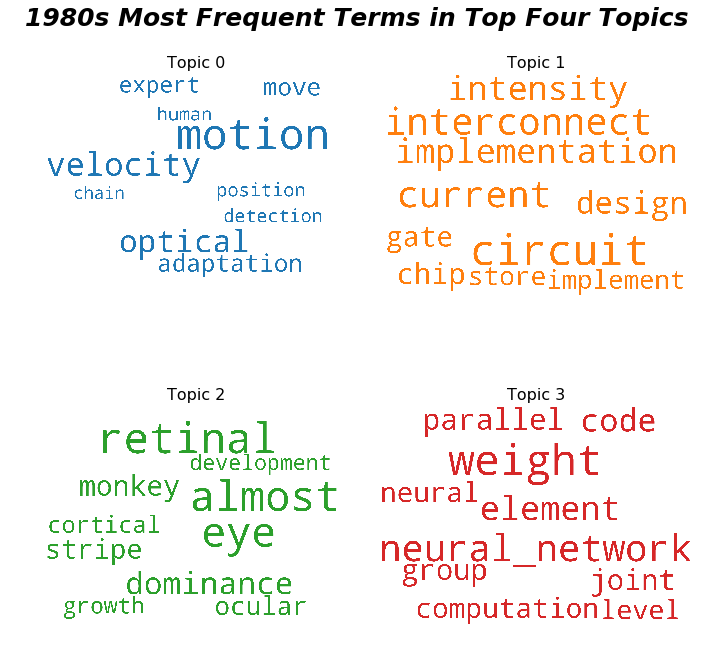

In [144]:
# 1980s WORDCLOUDS
# Build 4 Word clouds of showing top N words in each topic
# from matplotlib import pyplot as plt
# from wordcloud import WordCloud, STOPWORDS
# import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_80s.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=340)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
    
plt.suptitle('1980s Most Frequent Terms in Top Four Topics', size=25, weight ='bold', fontstyle='italic')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('Natural_Language_Processing_NIPS_Papers/images/Cloud_1980s.png')
plt.show()


In [117]:
# Build 1990s LDA model
lda_model_90s = gensim.models.ldamodel.LdaModel(corpus=corp_1990s,
                                           id2word=dict_1990s,
                                           num_topics=14,         #this can be changed, 1990s per graph: either 8 or 14 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model_90s.print_topics())

[(0,
  '0.053*"code" + 0.048*"block" + 0.048*"character" + 0.043*"level" + '
  '0.029*"bit" + 0.028*"role" + 0.027*"group" + 0.026*"compression" + '
  '0.026*"constraint" + 0.026*"energy"'),
 (1,
  '0.023*"signal" + 0.022*"pattern" + 0.016*"cell" + 0.015*"visual" + '
  '0.015*"model" + 0.011*"frequency" + 0.011*"response" + 0.010*"synaptic" + '
  '0.009*"spike" + 0.009*"phase"'),
 (2,
  '0.065*"image" + 0.043*"feature" + 0.031*"object" + 0.018*"view" + '
  '0.017*"recognition" + 0.014*"visual" + 0.013*"face" + 0.012*"distance" + '
  '0.010*"pattern" + 0.010*"facial"'),
 (3,
  '0.056*"current" + 0.042*"voltage" + 0.035*"control" + 0.031*"chip" + '
  '0.027*"gate" + 0.024*"circuit" + 0.023*"controller" + '
  '0.021*"implementation" + 0.020*"float" + 0.020*"plant"'),
 (4,
  '0.023*"model" + 0.013*"distribution" + 0.012*"parameter" + 0.011*"estimate" '
  '+ 0.010*"probability" + 0.008*"variance" + 0.008*"sample" + 0.007*"term" + '
  '0.007*"obtain" + 0.006*"estimator"'),
 (5,
  '0.144*"net

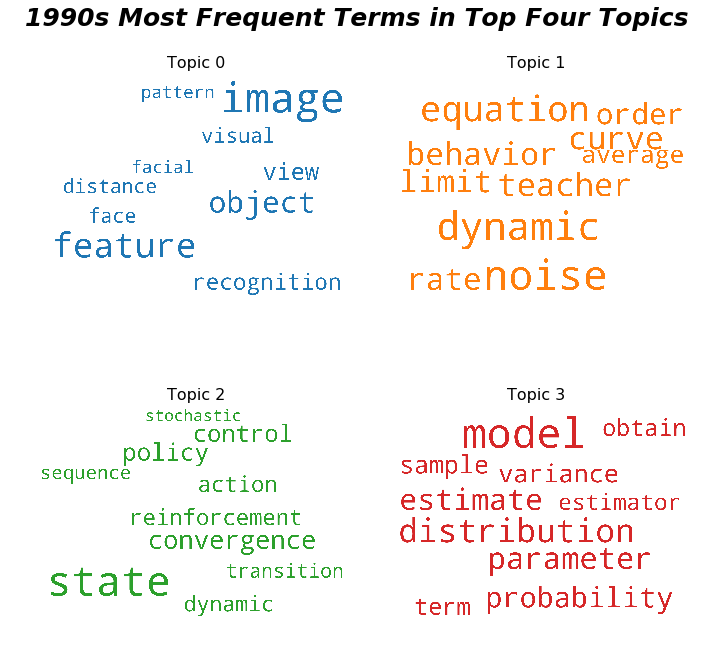

In [122]:
# 1990s WORDCLOUDS
# Build 4 Word clouds of showing top N words in each topic
# from matplotlib import pyplot as plt
# from wordcloud import WordCloud, STOPWORDS
# import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_90s.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=330)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
    
plt.suptitle('1990s Most Frequent Terms in Top Four Topics', size=25, weight ='bold', fontstyle='italic')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('Natural_Language_Processing_NIPS_Papers/images/Cloud_1990s.png')
plt.show()


In [123]:
# Build 2000s LDA model
lda_model_00s = gensim.models.ldamodel.LdaModel(corpus=corp_2000s,
                                           id2word=dict_2000s,
                                           num_topics=14,         #this can be changed, 2000s per graph: either 8 or 14 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model_00s.print_topics())

[(0,
  '0.043*"model" + 0.024*"response" + 0.022*"subject" + 0.022*"human" + '
  '0.019*"functional" + 0.016*"brain" + 0.016*"trial" + 0.014*"stimulus" + '
  '0.014*"movement" + 0.014*"experiment"'),
 (1,
  '0.104*"tree" + 0.081*"word" + 0.066*"topic" + 0.031*"language" + '
  '0.030*"structure" + 0.028*"model" + 0.025*"node" + 0.019*"discover" + '
  '0.018*"modeling" + 0.016*"context"'),
 (2,
  '0.047*"signal" + 0.046*"sparse" + 0.039*"code" + 0.032*"rate" + '
  '0.023*"neural" + 0.022*"response" + 0.020*"population" + '
  '0.019*"correlation" + 0.016*"threshold" + 0.015*"potential"'),
 (3,
  '0.060*"learn" + 0.049*"feature" + 0.029*"training" + 0.019*"classification" '
  '+ 0.019*"task" + 0.018*"performance" + 0.018*"learning" + 0.018*"train" + '
  '0.017*"label" + 0.017*"class"'),
 (4,
  '0.106*"loss" + 0.055*"regression" + 0.049*"function" + 0.045*"convex" + '
  '0.043*"optimization" + 0.034*"norm" + 0.026*"estimation" + '
  '0.022*"estimator" + 0.021*"minimize" + 0.020*"regularize"

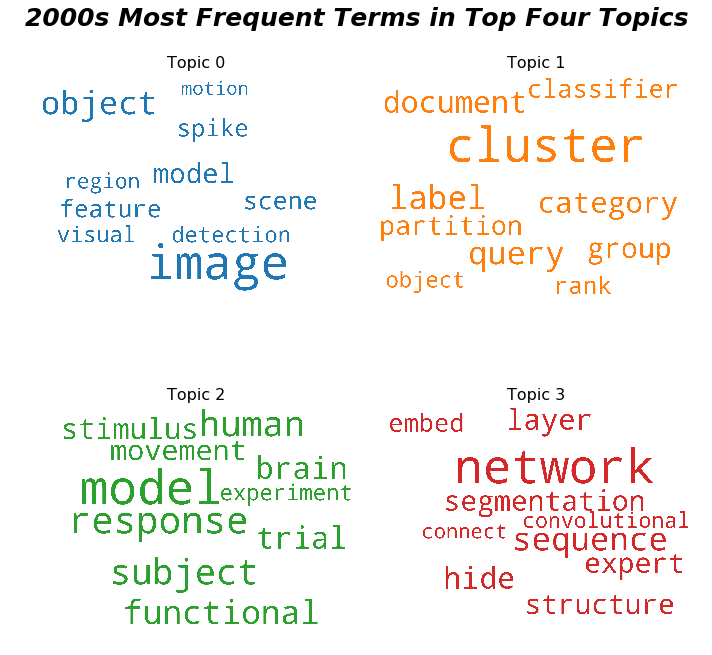

In [126]:
# 2000s WORDCLOUDS
# Build 4 Word clouds of showing top N words in each topic
# from matplotlib import pyplot as plt
# from wordcloud import WordCloud, STOPWORDS
# import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_00s.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=380)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
    
plt.suptitle('2000s Most Frequent Terms in Top Four Topics', size=25, weight ='bold', fontstyle='italic')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('Natural_Language_Processing_NIPS_Papers/images/Cloud_2000s.png')
plt.show()


In [127]:
# Build 2010s LDA model
lda_model_10s = gensim.models.ldamodel.LdaModel(corpus=corp_2010s,
                                           id2word=dict_2010s,
                                           num_topics=20,         #this can be changed, 2010s per graph: either 8 or 20 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model_10s.print_topics())

[(0,
  '0.105*"kernel" + 0.086*"estimator" + 0.067*"estimate" + 0.064*"estimation" '
  '+ 0.049*"regression" + 0.038*"density" + 0.029*"gaussian" + '
  '0.029*"function" + 0.027*"covariance" + 0.018*"sample"'),
 (1,
  '0.194*"sequence" + 0.144*"prediction" + 0.110*"game" + 0.072*"predict" + '
  '0.051*"expert" + 0.051*"strategy" + 0.035*"future" + 0.034*"action" + '
  '0.027*"play" + 0.025*"frame"'),
 (2,
  '0.062*"learn" + 0.040*"training" + 0.036*"feature" + 0.033*"train" + '
  '0.031*"task" + 0.017*"classification" + 0.017*"loss" + 0.017*"dataset" + '
  '0.017*"architecture" + 0.016*"learning"'),
 (3,
  '0.032*"noise" + 0.024*"signal" + 0.016*"reconstruction" + 0.016*"neural" + '
  '0.015*"code" + 0.015*"filter" + 0.015*"hash" + 0.013*"brain" + '
  '0.012*"residual" + 0.011*"measurement"'),
 (4,
  '0.123*"image" + 0.043*"object" + 0.024*"model" + 0.023*"visual" + '
  '0.022*"map" + 0.017*"segmentation" + 0.015*"vision" + 0.014*"generate" + '
  '0.013*"recognition" + 0.012*"video"'),

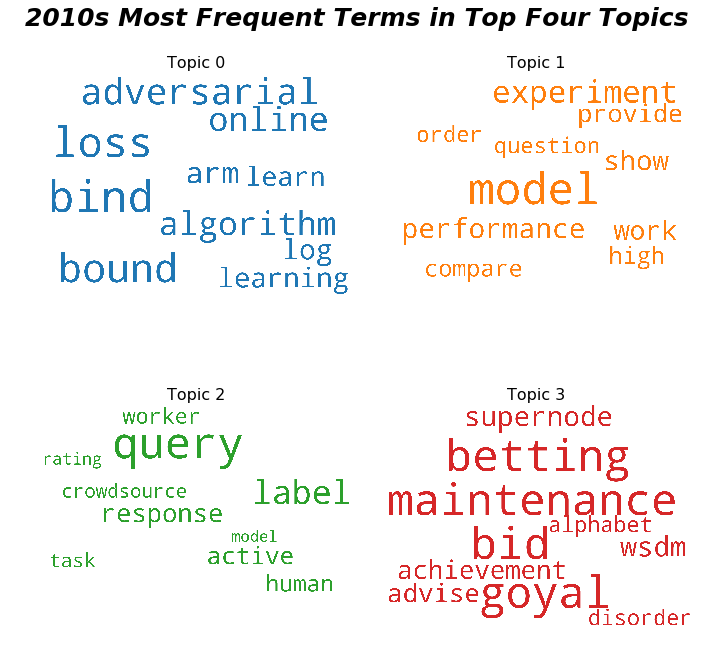

In [132]:
# 2010s WORDCLOUDS
# Build 4 Word clouds of showing top N words in each topic
# from matplotlib import pyplot as plt
# from wordcloud import WordCloud, STOPWORDS
# import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_10s.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=350)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
    
plt.suptitle('2010s Most Frequent Terms in Top Four Topics', size=25, weight ='bold', fontstyle='italic')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('Natural_Language_Processing_NIPS_Papers/images/Cloud_2010s.png')
plt.show()


## LDAvis viewing tool, for each decade:

In [145]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

In [146]:
# Prepare LDAvis for 1980's documents
# the number of topics should be optimized iteratively
n_topics = 14
topics_1980s = LdaModel(corpus=corp_1980s,
                           id2word=dict_1980s,
                           num_topics=n_topics,
                           passes=10)

# Save LDAvis to html file
p = pyLDAvis.gensim.prepare(topics_1980s, corp_1980s, dict_1980s)
pyLDAvis.save_html(p, 'lda_1980s.html')

# Prepare and display LDAvis
vis_data = gensimvis.prepare(topics_1980s, 
                             corp_1980s, 
                             dict_1980s)
pyLDAvis.display(vis_data)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [147]:
# 1990s documents
# the number of topics should be optimized iteratively
n_topics = 14
topics_1990s = LdaModel(corpus=corp_1990s,
                           id2word=dict_1990s,
                           num_topics=n_topics,
                           passes=10)

# Save LDAvis to html file
p = pyLDAvis.gensim.prepare(topics_1990s, corp_1990s, dict_1990s)
pyLDAvis.save_html(p, 'lda_1990s.html')

# Prepare and display LDAvis
vis_data = gensimvis.prepare(topics_1990s, 
                             corp_1990s, 
                             dict_1990s)
pyLDAvis.display(vis_data)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [148]:
# 2000s documents
# the number of topics should be optimized iteratively
n_topics = 14
topics_2000s = LdaModel(corpus=corp_2000s,
                           id2word=dict_2000s,
                           num_topics=n_topics,
                           passes=10)

# Save LDAvis to html file
p = pyLDAvis.gensim.prepare(topics_2000s, corp_2000s, dict_2000s)
pyLDAvis.save_html(p, 'lda_2000s.html')

# Prepare and display LDAvis
vis_data = gensimvis.prepare(topics_2000s, 
                             corp_2000s, 
                             dict_2000s)
pyLDAvis.display(vis_data)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [149]:
# 2010s documents
# the number of topics should be optimized iteratively
n_topics = 20
topics_2010s = LdaModel(corpus=corp_2010s,
                           id2word=dict_2010s,
                           num_topics=n_topics,
                           passes=10)

# Save LDAvis to html file
p = pyLDAvis.gensim.prepare(topics_1980s, corp_1980s, dict_1980s)
pyLDAvis.save_html(p, 'lda_2010s.html')

# Prepare and display LDAvis
vis_data = gensimvis.prepare(topics_2010s, 
                             corp_2010s, 
                             dict_2010s)
pyLDAvis.display(vis_data)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
